In [1]:
!pip install -q matplotlib seaborn numpy tensorflow==2.0.0b tqdm sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

tf.__version__

You should consider upgrading via the 'pip install --upgrade pip' command.


/Users/martinhwasser/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/martinhwasser/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/martinhwasser/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/martinhwasser/venv/lib/python3.7/site-packages/tensorflow/python/f

'2.0.0-beta0'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

CMAP = ListedColormap(sns.color_palette('RdBu_r', 16))
pd.set_option('display.max_columns', None)

# ==================================

## Cell 2
plt.style.use('fivethirtyeight')
sns.set_style('white', {'axes.grid': True})
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['image.cmap'] = 'coolwarm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = False
mpl.rcParams['savefig.dpi'] = 240
mpl.rcParams['savefig.facecolor'] = 'white'

# Get data

In [3]:
df = pd.read_csv('data/transactions_id.csv')
df_bad = pd.read_csv('data/transactions_bad.csv')
df.head()

,arrival,carrier,co2,departure,distance,dwell,from_lat,from_lon,from_name,mode,shipment,step,time,to_lat,to_lon,to_name
0,2018-01-23 06:51:51.757542,3,5456.697873,2018-01-22 22:28:00.000000,6718.168343,2018-01-22 22:28:00.000000,-11.05248,26.54665,9,plane,ship00000,0,8.397710,43.26271,-2.92528,1
1,2018-01-23 21:17:40.041767,0,1579.026421,2018-01-23 18:51:51.757542,1944.063161,2018-01-23 06:51:51.757542,43.26271,-2.92528,1,plane,ship00000,1,2.430079,58.27429,11.43576,10
2,2018-01-24 00:23:07.625214,3,708.911356,2018-01-23 23:17:40.041767,872.796321,2018-01-23 21:17:40.041767,58.27429,11.43576,10,plane,ship00000,2,1.090995,64.62477,21.07689,7
3,2017-10-31 08:06:48.120671,2,882.364230,2017-10-25 17:45:00.000000,6718.168343,2017-10-25 17:45:00.000000,-11.05248,26.54665,9,truck,ship00001,0,134.363367,43.26271,-2.92528,1
4,2017-11-02 13:54:06.130720,3,195.620003,2017-11-01 08:06:48.120671,1489.416806,2017-10-31 08:06:48.120671,43.26271,-2.92528,1,truck,ship00001,1,29.788336,53.57532,10.01534,2


In [4]:
def get_data(df):
    max_idx = int(max(df['from_name']))

    oh_size = max_idx + 1
    df = df[['from_name', 'to_name', 'time']]

    frm, to, times = [], [], []
    for x in df.values:
        frm.append(np.eye(oh_size)[int(x[0])])
        to.append(np.eye(oh_size)[int(x[1])])
        times.append([x[2]])
    return frm, to, times, oh_size

In [5]:
def split_train_test(frm, to, times):
    size = len(frm)

    frm_train = frm[:int(size*0.8)]
    to_train = to[:int(size*0.8)]
    times_train = times[:int(size*0.8)]
    X_train = [frm_train, to_train, times_train]

    frm_test = frm[int(size*0.8):]
    to_test = to[int(size*0.8):]
    times_test = times[int(size*0.8):]
    X_test = [frm_test, to_test, times_test]
    
    return X_train, X_test

In [6]:
frm, to, times, oh_size = get_data(df)
scaler = StandardScaler()
times = scaler.fit_transform(times)

with open('scaler.pkl', 'wb') as f:
    import pickle
    pickle.dump(scaler, f)
X_train, X_test = split_train_test(frm, to, times)

# Define Autoencoder model

In [7]:
from_input = Input(shape=(oh_size,))
to_input = Input(shape=(oh_size,))
time_input = Input(shape=(1,))

x = Dense(32, activation='relu')(from_input)
x = Dense(32, activation='relu')(x)
encoded0 = Dense(2, activation='relu')(x)

x = Dense(32, activation='relu')(to_input)
x = Dense(32, activation='relu')(x)
encoded1 = Dense(2, activation='relu')(x)

x = Dense(32, activation='relu')(time_input)
x = Dense(32, activation='relu')(x)
encoded2 = Dense(2, activation='relu')(x)

encoded = tf.keras.layers.concatenate([encoded0, encoded1, encoded2])

x = Dense(32, activation='relu')(encoded)
x = Dense(32, activation='relu')(encoded)

from_out = Dense(oh_size, activation='softmax')(x)
to_out = Dense(oh_size, activation='softmax')(x)
time_out = Dense(1)(x)

autoencoder = Model([from_input, to_input, time_input], [from_out, to_out, time_out])
autoencoder.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy', 'mse'], loss_weights=[1., 1., 1.])

In [8]:
history = autoencoder.fit(X_train, X_train, epochs=300, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


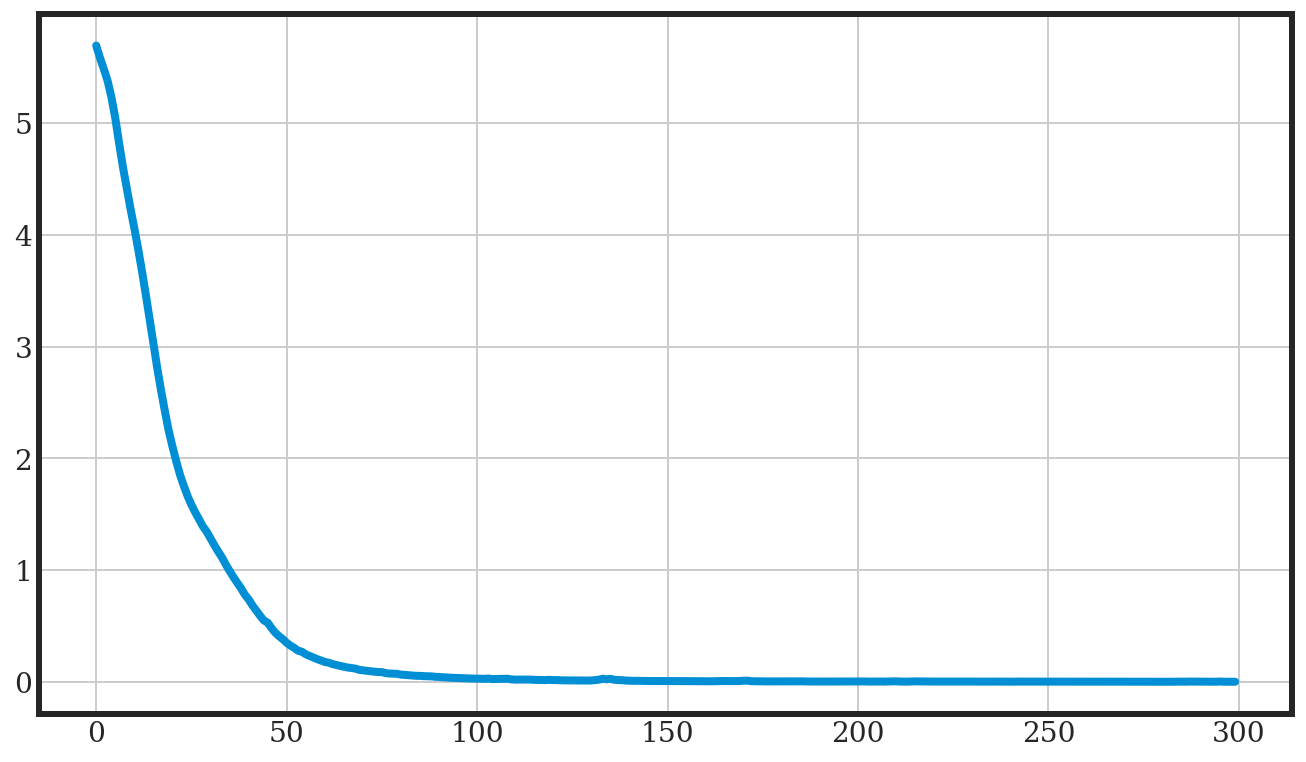

In [9]:
plt.plot(history.history['loss'])

# Test on normal data

In [10]:
pred = autoencoder.predict(X_test, verbose=0)
score = autoencoder.evaluate(X_test, X_test)
print('Score for test (good):', score)
pred_from, pred_to, pred_t = pred

60/60 [==============================] - 0s 1ms/sample - loss: 0.0019 - dense_11_loss: 5.8991e-04 - dense_12_loss: 2.9738e-04 - dense_13_loss: 0.0011
Score for test (good): [0.0019032247985402743, 0.00058991497, 0.00029737738, 0.0010699725]


In [11]:
frm_bad, to_bad, times_bad, _ = get_data(df_bad)
times_bad = scaler.transform(times_bad)

# Test on bad/anomalous data

In [12]:
X_test_bad = [frm_bad[:1], to_bad[:1], times_bad[:1]]
pred = autoencoder.predict(X_test, verbose=0)
score = autoencoder.evaluate(X_test, X_test)
print('Score for test (good):', score)
pred_from, pred_to, pred_t = pred

pred = autoencoder.predict(X_test_bad, verbose=0)
score = autoencoder.evaluate(X_test_bad, X_test_bad)
print('Score for test (bad):', score)
pred_from, pred_to, pred_t = pred

60/60 [==============================] - 0s 46us/sample - loss: 0.0019 - dense_11_loss: 5.8991e-04 - dense_12_loss: 2.9738e-04 - dense_13_loss: 0.0011
Score for test (good): [0.0019032247985402743, 0.00058991497, 0.00029737738, 0.0010699725]
1/1 [==============================] - 0s 41ms/sample - loss: 15321.8818 - dense_11_loss: 16.1181 - dense_12_loss: 16.1181 - dense_13_loss: 15289.6455
Score for test (bad): [15321.8818359375, 16.118095, 16.118095, 15289.6455]


In [13]:
autoencoder.save('model.h5')

In [14]:
from IPython.display import HTML
HTML('<img src="thumbsup.gif">')